In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import glob as glob
import os

In [4]:
import albumentations as A

In [5]:
def crop_bounding_boxes(x_min = None, y_min = None, x_max = None, y_max = None):
    return A.Compose([
        A.Crop(x_min = x_min, y_min = y_min, x_max = x_max, y_max = y_max)
    ])

In [6]:
# training images and XML files directory
TRAIN_DIR = 'data/out_rgb'
# validation images and XML files directory
VALID_DIR = 'data/out_rgb'

dir_path = TRAIN_DIR

image_paths = glob.glob(f"{dir_path}/*.png")
all_images = [image_path.split('/')[-1].split('.')[0] for image_path in image_paths]
all_images = sorted(all_images)

boxed_image_dir = 'data/out_rgb_bbox'
boxed_image_paths = glob.glob(f"{boxed_image_dir}/*.png")
all_boxed_images = [boxed_image_path.split('/')[-1].split('.')[0] for boxed_image_path in boxed_image_paths]
all_boxed_images = sorted(all_boxed_images)


# FileNames Dictionary
filenames = dict()
for sub_dir, dir_name, files in os.walk("data/out_bbox/"):
    for file in files:
        try:
            with open("data/out_bbox/" + file, 'r') as fp:
                file = file.split('.')[0]
                filenames[file] = json.load(fp)
        except Exception as e:
            pass

In [7]:
len(filenames)

2798

In [8]:
len(all_images)

2779

In [9]:
len(all_boxed_images)

2779

In [10]:
sample_image = "134698"
image_annotation = filenames[sample_image]
boxes = []
if image_annotation["bboxes"]:
    for box_coordinates in image_annotation["bboxes"]:
        if box_coordinates:
            x_min = box_coordinates[0][0]
            y_min = box_coordinates[0][1]
            x_max = box_coordinates[1][0]
            y_max = box_coordinates[1][1]
            boxes.append([x_min, y_min, x_max, y_max])
print(boxes)

[[584.5990071947347, 330.1428855212734, 740.8814361405255, 402.92577998910133]]


In [11]:
x_min, y_min, x_max, y_max = boxes[0]

In [12]:
image_path = os.path.join(dir_path, sample_image + '.png')
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

In [13]:
image.shape

(600, 800, 3)

In [14]:
image_resized = cv2.resize(image, (512, 512))
image_resized.shape

(512, 512, 3)

In [15]:
from albumentations.augmentations.crops.transforms import Crop

In [16]:
crop = Crop()

In [17]:
print(type(x_min))
transform = A.Compose(
    [
        Crop(x_min=int(x_min), y_min=int(y_min), x_max=int(x_max), y_max=int(y_max))
    ])
transformed_image = transform(image = image)

<class 'float'>


In [18]:
image.shape

(600, 800, 3)

In [19]:
transformed_image['image'].shape

(72, 156, 3)

In [22]:
print(torch.tensor(transformed_image['image']).shape)
sampled_image = torch.tensor(transformed_image['image'])
sampled_image = cv2.cvtColor(np.float32(sampled_image), cv2.COLOR_RGB2GRAY)
fig = plt.figure()
plt.imshow(sampled_image)
plt.savefig('transformed_image.png')
plt.close(fig)

torch.Size([72, 156, 3])


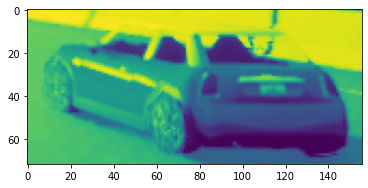

In [23]:
plt.imshow(sampled_image)

In [24]:
image.shape

(600, 800, 3)

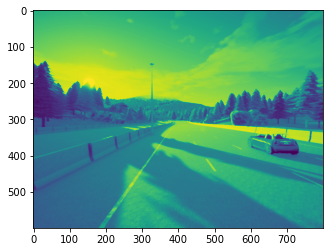

In [25]:
image = cv2.cvtColor(np.float32(image), cv2.COLOR_RGB2GRAY)
plt.imshow(image)

In [51]:
images_with_boxes = []
images_without_boxes = []
vehicle_class_dictionary = dict()
for filename in filenames.keys():
    image_annotation = filenames[filename]
    boxes = []
    vehicle_classes = []
    if image_annotation["bboxes"]:
        for box_coordinates in image_annotation["bboxes"]:
            if box_coordinates:
                x_min = box_coordinates[0][0]
                y_min = box_coordinates[0][1]
                x_max = box_coordinates[1][0]
                y_max = box_coordinates[1][1]
                boxes.append([x_min, y_min, x_max, y_max])
        for vehicle_class in image_annotation["vehicle_class"]:
            vehicle_classes.append(str(vehicle_class))
    if boxes:
        images_with_boxes.append(filename)
        for index, box in enumerate(boxes):
            try:
                x_min, y_min, x_max, y_max = box
                image_path = os.path.join(dir_path, filename + '.png')
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
                transform = A.Compose(
                    [
                        Crop(x_min=int(x_min), y_min=int(y_min), x_max=int(x_max), y_max=int(y_max))
                    ])
                transformed_image = transform(image = image)
                sampled_image = torch.tensor(transformed_image['image'])
                sampled_image = cv2.cvtColor(np.float32(sampled_image), cv2.COLOR_RGB2GRAY)
                fig = plt.figure()
                plt.imshow(sampled_image)
                plt.savefig('data/cropped_images/' + filename + '_{image_index}.png'.format(image_index=index))
                vehicle_class_dictionary[filename + "_{image_index}".format(image_index=index)] = vehicle_classes[index]
                plt.close(fig)
            except Exception as e:
                print(e)
    else:
        images_without_boxes.append(filename)

Values for crop should be non negative and equal or smaller than image sizes(x_min = -12, y_min = 313, x_max = 61, y_max = 341, height = 600, width = 800)
Values for crop should be non negative and equal or smaller than image sizes(x_min = -18, y_min = 336, x_max = 189, y_max = 424, height = 600, width = 800)
Values for crop should be non negative and equal or smaller than image sizes(x_min = 227, y_min = -524, x_max = 418, y_max = -304, height = 600, width = 800)
Values for crop should be non negative and equal or smaller than image sizes(x_min = -59, y_min = 339, x_max = 195, y_max = 443, height = 600, width = 800)
Values for crop should be non negative and equal or smaller than image sizes(x_min = -60, y_min = 313, x_max = 190, y_max = 440, height = 600, width = 800)
Values for crop should be non negative and equal or smaller than image sizes(x_min = -43, y_min = 338, x_max = 195, y_max = 436, height = 600, width = 800)
Values for crop should be non negative and equal or smaller tha

In [27]:
with open('images_with_boxes.json', 'w') as fp:
    json.dump(images_with_boxes, fp, indent=4)

In [28]:
with open('images_without_boxes.json', 'w') as fp:
    json.dump(images_without_boxes, fp, indent=4)

In [29]:
images_without_boxes[:5]

['004535', '004555', '004575', '004595', '004615']

In [30]:
images_with_boxes[:5]

['105855', '105875', '105895', '105915', '105955']

In [31]:
from albumentations.augmentations.crops.transforms import RandomCrop

In [47]:
for filename in images_without_boxes:
    try:
        image_path = os.path.join(dir_path, filename + '.png')
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        random_crop_transform = A.Compose(
            [
                RandomCrop(height=150, width=150)
            ])
        transformed_image = random_crop_transform(image = image)
        sampled_image = torch.tensor(transformed_image['image'])
        sampled_image = cv2.cvtColor(np.float32(sampled_image), cv2.COLOR_RGB2GRAY)
        fig = plt.figure()
        plt.imshow(sampled_image)
        plt.savefig('data/random_cropped/' + filename + '.png')
        plt.close(fig)
    except Exception as e:
        pass

In [48]:
# -------------------------- Rough -----------------------------

In [40]:
image_set = set(all_boxed_images)

In [41]:
filename = "105895"
image_path = os.path.join(dir_path, filename + '.png')
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
random_crop_transform = A.Compose(
    [
        RandomCrop(height=150, width=150)
    ])
transformed_image = random_crop_transform(image = image)

In [42]:
image.shape

(600, 800, 3)

In [44]:
transformed_image['image'].shape

(150, 150, 3)

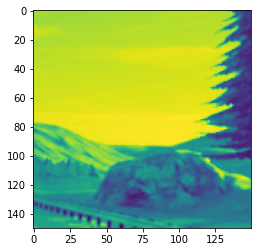

In [45]:
sampled_image = torch.tensor(transformed_image['image'])
sampled_image = cv2.cvtColor(np.float32(sampled_image), cv2.COLOR_RGB2GRAY)
plt.imshow(sampled_image)

In [50]:
# --------------------------------------------------------------

In [54]:
list(vehicle_class_dictionary.keys())[:5]

['105855_0', '105855_1', '105875_0', '105875_1', '105895_0']

In [56]:
with open("vehicle_class_dict.json", "w") as fp:
    json.dump(vehicle_class_dictionary, fp, indent=4)

In [57]:
# --------------------------------------------------------------

In [61]:
len(set(vehicle_class_dictionary.values()))

4

In [62]:
set(vehicle_class_dictionary.values())

{'0', '1', '2', '3'}

In [63]:
import os
os.path.join('karthik', 'ragunath', 'ananda', 'kumar')

'karthik/ragunath/ananda/kumar'

In [64]:
tensor_data = torch.tensor([1,2,3,4]).shape

In [65]:
tensor_data

torch.Size([4])